In [1]:
import numpy as np
import pandas as pd
import scipy.linalg as sla
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.linear_model import LinearRegression, Lasso, Ridge

# 1. Линейная регрессия

Линейные методы предполагают, что между  объекта (features) и целевой переменной (target/label) существует линейная зависимость, то есть
$$y = w_1 x_1 + w_2 x_2 + ... + w_k x_k + b, $$ где $у$ --- целевая переменная (что мы хотим предсказать), $x_i$ --- признак объекта $х$, $w_i$ --- вес $i$-го признака, $b$ --- bias (смещение, свободный член)

Часто предполагают, что объект $х$ содержит в себе фиктивный признак равный 1 для представления свободного члена $b$. В этом случае формула принимает простой вид:
$$y = \langle w, x \rangle,$$
где $\langle \cdot, \cdot \rangle$ -- скалярное произведение векторов $w, x \in \mathbb{R}^n$.

В матричной форме, в случае, когда у нас есть $m$ объектов формулу можно переписать следующим образом:
$$ Y = Xw, $$ где $Y$ -- столбец размера $n$, $X$ --- матрица признаков размера $n \times k$ (каждая строка матрицы есть описание признаков объекта), $w$ -- вектор весов размера $k$.

**Лосс:** 
$$
\begin{aligned}
L(y_{pred}, Y) &= \frac{1}{n}||y_{pred} - Y||^2_2 =\\
&= \frac{1}{n}||Xw - Y||^2_2 = \frac{1}{n}\sum_{i=1}^{n}\left(\sum_{j=1}^{m} x_{ij}w_j - y_i\right)^2 =: L(w)
\end{aligned}
$$

### 1.1 Аналитическое решение

Минимизация ошибки по методу наименьших квадратов дает решение: $$ w = (X^TX)^{-1}X^TY $$

Реализуем класс линейной регрессии с помощью этой формулы.

In [2]:
class MyLinearRegression:
    def __init__(self, fit_intercept=True):
        self.fit_intercept = fit_intercept

    def fit(self, X, y):
        # Принимает на вход X, y и вычисляет веса по данной выборке
        # Не забудьте про фиктивный признак равный 1
        
        n, k = X.shape
        
        X_train = X
        if self.fit_intercept:
            X_train = np.hstack((X, np.ones((n, 1))))

        self.w = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y

        return self
        
    def predict(self, X):
        # Принимает на вход X и возвращает ответы модели
        # Не забудьте про фиктивный признак равный 1
        n, k = X.shape
        if self.fit_intercept:
            X_train = np.hstack((X, np.ones((n, 1))))

        y_pred = X_train @ self.w

        return y_pred
    
    def get_weights(self):
        return self.w

#### Тестирование
Сначала сгенерируем искусственные данные для теста моделей

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
def linear_expression(x):
    return 4* x + 30

In [5]:
# по признакам сгенерируем значения таргетов с некоторым шумом
objects_num = 50
X = np.linspace(-5, 5, objects_num)
y = linear_expression(X) + np.random.randn(objects_num) * 5

# выделим половину объектов на тест
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5)

Нанесем точки выборки и зависимость на график для наглядности

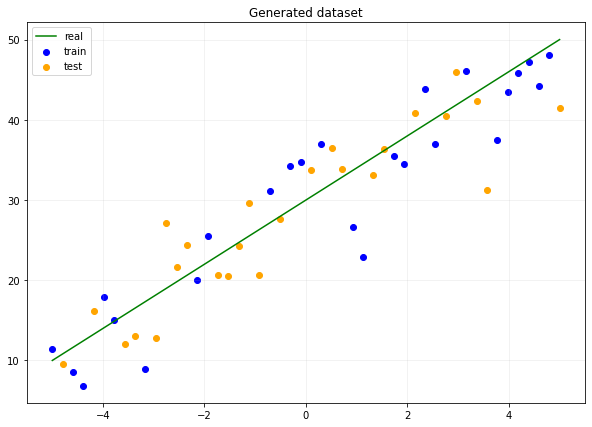

In [6]:
plt.figure(figsize=(10, 7))
plt.plot(X, linear_expression(X), label='real', c='g')
plt.scatter(X_train, y_train, label='train', c='b')
plt.scatter(X_test, y_test, label='test', c='orange')

plt.title("Generated dataset")
plt.grid(alpha=0.2)
plt.legend()
plt.show()

Обучим модель на трейне и предскажем результаты на тесте

In [7]:
regressor = MyLinearRegression()

regressor.fit(X_train[:, np.newaxis], y_train)

predictions = regressor.predict(X_test[:, np.newaxis])
w = regressor.get_weights()
w

array([ 3.84806908, 29.07441674])

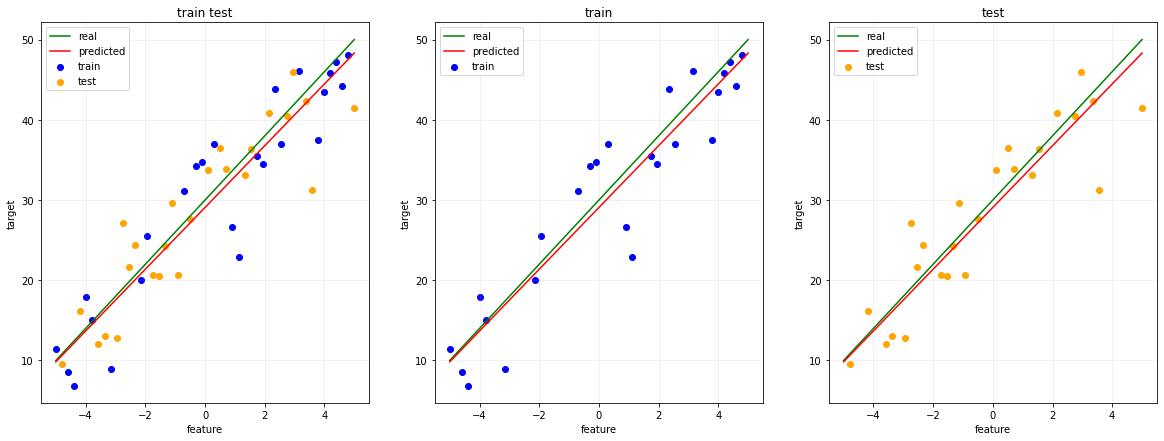

In [8]:
plt.figure(figsize=(20, 7))

ax = None

for i, types in enumerate([['train', 'test'], ['train'], ['test']]):
    ax = plt.subplot(1, 3, i + 1, sharey=ax)
    if 'train' in types:
        plt.scatter(X_train, y_train, label='train', c='b')
    if 'test' in types:
        plt.scatter(X_test, y_test, label='test', c='orange')

    plt.plot(X, linear_expression(X), label='real', c='g')
    plt.plot(X, regressor.predict(X[:, np.newaxis]), label='predicted', c='r')

    plt.ylabel('target')
    plt.xlabel('feature')
    plt.title(" ".join(types))
    plt.grid(alpha=0.2)
    plt.legend()

plt.show()

Сравним с реализацией из sklearn

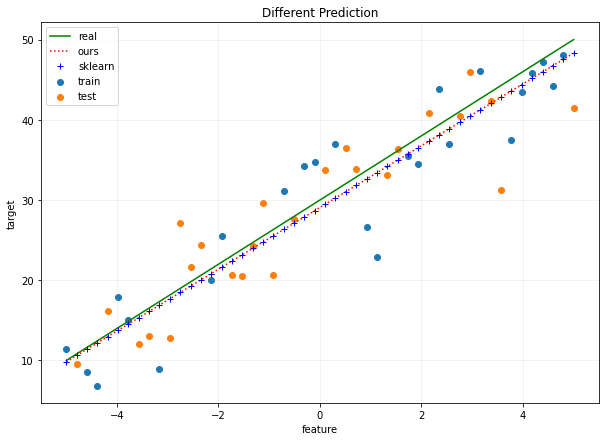

In [9]:
sk_reg = LinearRegression().fit(X_train[:, np.newaxis], y_train)

plt.figure(figsize=(10, 7))
plt.plot(X, linear_expression(X), label='real', c='g')

plt.scatter(X_train, y_train, label='train')
plt.scatter(X_test, y_test, label='test')
plt.plot(X, regressor.predict(X[:, np.newaxis]), label='ours', c='r', linestyle=':')
plt.plot(X, sk_reg.predict(X[:, np.newaxis]), label='sklearn', c='b', linestyle='',marker='+')

plt.title("Different Prediction")
plt.ylabel('target')
plt.xlabel('feature')
plt.grid(alpha=0.2)
plt.legend()
plt.show()

#### Результаты

In [10]:
from sklearn.metrics import mean_squared_error

train_predictions = regressor.predict(X_train[:, np.newaxis])
test_predictions = regressor.predict(X_test[:, np.newaxis])

print('Train MSE: ', mean_squared_error(y_train, train_predictions))
print('Test MSE: ', mean_squared_error(y_test, test_predictions))

Train MSE:  21.53974678618051
Test MSE:  19.699257974698796


### 1.2. Градиентная оптимизация

Обращение матрицы -- очень долгая операция. Кроме того, обратная матрица $(X^TX)^{-1}$ не всегда существует. По этим причинам, мы воспользуемся методом градиентного спуска для оптимизации эмпирического риска.

Градиентый спуск заключается в 
1. расчете $\displaystyle\frac{\partial{L}}{\partial{w}}$ -- градиента ошибки (значение целевой функции, то есть лосса $L(y_{pred}, y_{true})$) от значения параметров модели (весов $w$)
2. шаге спуска -- изменении весов $w$ в сторону антиградиента с некоторым коэффициентом $h$ (он же learning rate):
$$w := w - h\frac{\partial{L}}{\partial{w}}$$
3. Повторении п.1 и п.2 пока не наблюдается сходимость (изменения ошибки малы или отсутсвуют)

Как правило, чаще используют стохастический градиентный спуск (SGD): выбирают случайный элемент обучающей выборки и изменяют коэффициенты модели по направлению антиградиента функции потерь на этом примере.

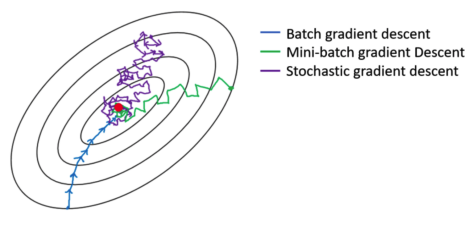

**Цель:** Реализуем новые классы линейной регрессии, в которой оптимизация проводится методами градиентного спуска.

**Предполагаемая зависимость:** $Y = Xw$, где $Y \in \mathbb{R}^{n\times 1}, X \in \mathbb{R}^{n\times m}, w \in \mathbb{R}^{m\times 1}$


**Минимизируемая функция:**
$$
L(y_{pred}, Y) = \frac{1}{n} ||y_{pred} - Y||^2 = \frac{1}{n}||Xw - Y||^2 = \frac{1}{n}(Xw - Y)^T(Xw - Y) = \frac{1}{n}(w^TX^TXw - 2Y^TXw + Y^TY)
$$

**Градиент w.r.t. $w$:**
$$
\frac{\partial{L}}{\partial{w}} = \frac{2}{n}(X^TXw - X^TY) = \frac{2}{n}X^T(y_{pred} - Y) \,\, \in \mathbb{R}^{m \times 1}
$$

In [11]:
class MyGradientLinearRegression(MyLinearRegression):
    def __init__(self, **kwargs):
        super().__init__(**kwargs) # передает именные параметры родительскому конструктору
        self.w = None
    
    def fit(self, X, y, lr=0.01, max_iter=100):
        # Принимает на вход X, y и вычисляет веса по данной выборке
        # Не забудьте про фиктивный признак равный 1!

        n, k = X.shape

        # случайно инициализируем веса
        if self.w is None:
            self.w = np.random.randn(k + 1 if self.fit_intercept else k)
        
        X_train = np.hstack((X, np.ones((n, 1)))) if self.fit_intercept else X
        
        self.losses = []
        
        for iter_num in range(max_iter):
            y_pred = self.predict(X)
            self.losses.append(mean_squared_error(y_pred, y))

            grad = self._calc_gradient(X_train, y, y_pred)

            assert grad.shape == self.w.shape, f"gradient shape {grad.shape} is not equal weight shape {self.w.shape}"
            self.w -= lr * grad

        return self

    def _calc_gradient(self, X, y, y_pred):
        grad = 2 * (y_pred - y)[:, np.newaxis] * X
        grad = grad.mean(axis=0)
        return grad

    def get_losses(self):
        return self.losses

#### Тестирование

Посчитаем предсказания на сгенерированном датасете

In [12]:
regressor = MyGradientLinearRegression(fit_intercept=True)

l = regressor.fit(X_train[:, np.newaxis], y_train,lr=0.023, max_iter=250).get_losses()

predictions = regressor.predict(X_test[:, np.newaxis])
w = regressor.get_weights()

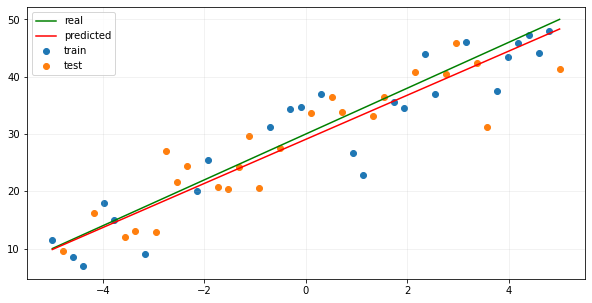

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(X, linear_expression(X), label='real', c='g')

plt.scatter(X_train, y_train, label='train')
plt.scatter(X_test, y_test, label='test')
plt.plot(X, regressor.predict(X[:, np.newaxis]), label='predicted', c='r')

plt.grid(alpha=0.2)
plt.legend()
plt.show()

Построим таккже график лосса во время обучения

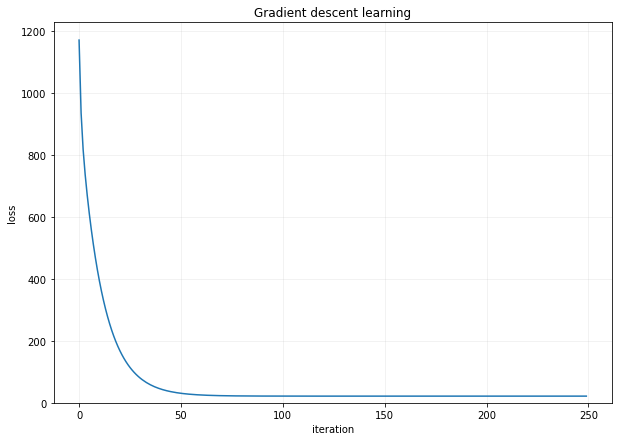

In [14]:
plt.figure(figsize=(10, 7))

plt.plot(l)

plt.title('Gradient descent learning')
plt.ylabel('loss')
plt.xlabel('iteration')
plt.ylim(bottom=0)
plt.grid(alpha=0.2)

plt.show()

### 1.3 SGD

Добавим к нашему градиентному спуску сэмплирование мини-батча, по которому будем считать градиент


In [15]:
class MySGDLinearRegression(MyGradientLinearRegression):
    def __init__(self, n_sample=10, **kwargs):
        super().__init__(**kwargs) # передает именные параметры родительскому конструктору
        self.w = None
        self.n_sample = n_sample

    def _calc_gradient(self, X, y, y_pred):
        # Главное отличие в SGD - это использование подвыборки для шага оптимизации
        inds = np.random.choice(np.arange(X.shape[0]), size=self.n_sample, replace=False)
        
        grad = 2 * (y_pred[inds] - y[inds])[:, np.newaxis] * X[inds]
        grad = grad.mean(axis=0)

        return grad

#### Тестирование

Проведем аналогичный расчет на сгенерированном датасете

In [16]:
regressor = MySGDLinearRegression(fit_intercept=True)

l = regressor.fit(X_train[:, np.newaxis], y_train, max_iter=100).get_losses()

predictions = regressor.predict(X_test[:, np.newaxis])
w = regressor.get_weights()

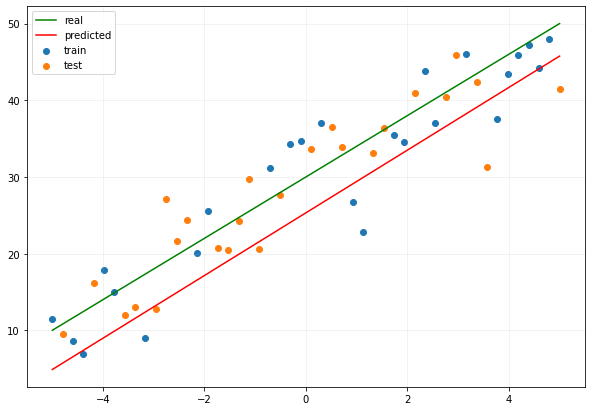

In [17]:
plt.figure(figsize=(10, 7))
plt.plot(X, linear_expression(X), label='real', c='g')

plt.scatter(X_train, y_train, label='train')
plt.scatter(X_test, y_test, label='test')
plt.plot(X, regressor.predict(X[:, np.newaxis]), label='predicted', c='r')

plt.grid(alpha=0.2)
plt.legend()
plt.show()

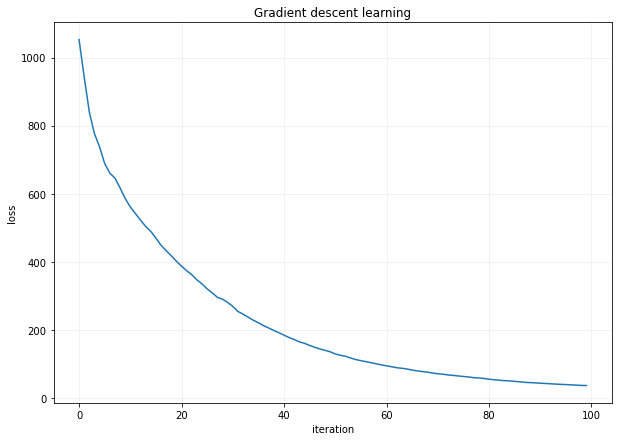

In [18]:
plt.figure(figsize=(10, 7))

plt.plot(l)

plt.title('Gradient descent learning')
plt.ylabel('loss')
plt.xlabel('iteration')
plt.grid(alpha=0.2)
plt.show()

Протестируем меняя количество элементов для расчета градиента

In [19]:
n_samples = [1, 2, 4]

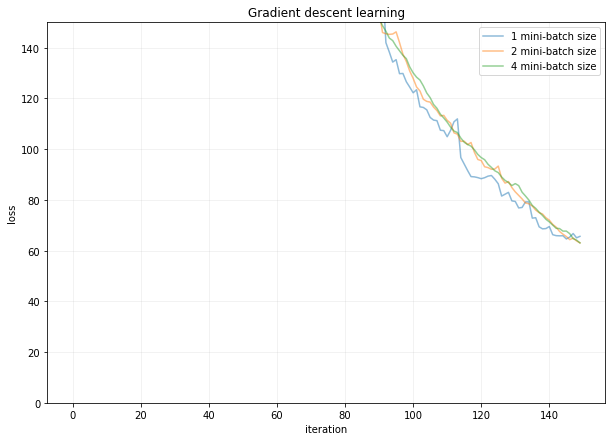

In [20]:
plt.figure(figsize=(10, 7))

for ns in n_samples:
    l = MySGDLinearRegression(fit_intercept=True, n_sample=ns).fit(
        X_train[:, np.newaxis],
        y_train,
        lr=5e-3,
        max_iter=150,
    ).get_losses()
    plt.plot(l, alpha=0.5, label=f'{ns} mini-batch size')

plt.title('Gradient descent learning')
plt.ylabel('loss')
plt.xlabel('iteration')

plt.legend()
plt.ylim((0, 150))
plt.grid(alpha=0.2)
plt.show()

Как видно по графикам размер подвыборки влияет на стабильность сходимости (чем меньше, тем больше и резче изменения весов).
При этом количество итераций для минимизации примерно одинаково.

SGD также обычно улучшают адаптивным уменьшением величины шага. (подробнее в курсах про методы оптимизаций итп)


# 2. Логистическая регрессия

Задание аналогичное линейной регрессии, только мы переводим выходной значение в вероятность предсказания класса 

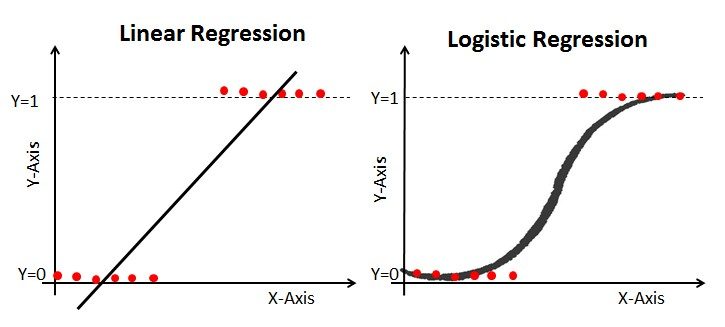



Для этого воспользуемся функцией: $\displaystyle\sigma(x) = \frac{1}{1 + e^{-x}}$

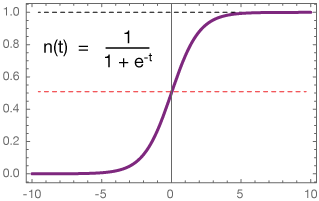

Задача теперь формулируется так:

**Предсказания:** $$
y_{pred}(x, w) = \frac{1}{1 + e^{-\langle x, w \rangle}}
$$

**Лосс (LogLoss):** $$
L(w) = -y\, log\,y_{pred} - (1-y)\,log\,(1-y_{pred})
$$

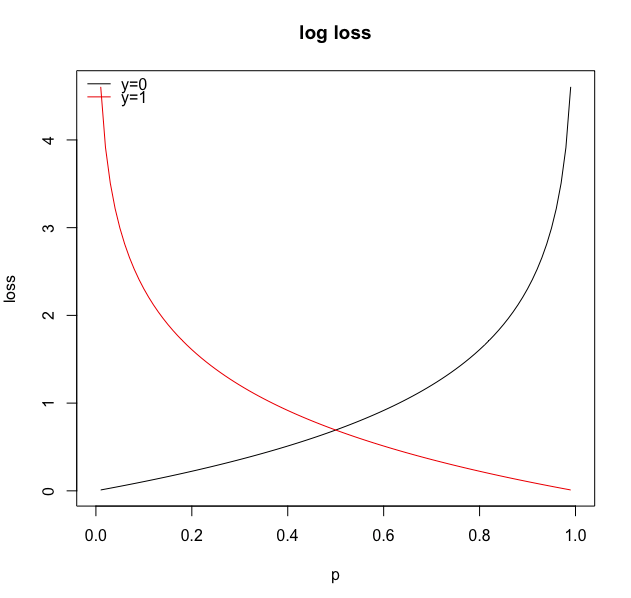

**Градиент:**
$$
\frac{\partial{L}}{\partial{w}}
= \left(-\frac{y}{y_{pred}} + \frac{1-y}{1-y_{pred}}\right)\frac{\partial{y_{pred}}}{\partial{w}}
$$

$$
\frac{\partial{y_{pred}}}{\partial{w}} = \frac{1}{(1+e^{-\langle x, w \rangle})^2} e^{-\langle x, w \rangle} (-x) = -y_{pred}(1-y_{pred})x
$$

$$
\frac{\partial{L}}{\partial{w}} = (y_{pred} - y) x
$$

In [21]:
def logit(x, w):
    return np.dot(x, w)

def sigmoid(h):
    return 1. / (1 + np.exp(-h))

class MyLogisticRegression(object):
    def __init__(self):
        self.w = None
    
    def fit(self, X, y, max_iter=100, lr=0.1):
        # Принимает на вход X, y и вычисляет веса по данной выборке.
        # Множество допустимых классов: {1, -1}
        # Не забудьте про фиктивный признак равный 1!
        
        n, k = X.shape
        
        if self.w is None:
            self.w = np.random.randn(k + 1)
        
        X_train = np.concatenate((np.ones((n, 1)), X), axis=1)
        
        losses = []
        
        for iter_num in range(max_iter):
            z = sigmoid(logit(X_train, self.w))
            grad = np.dot(X_train.T, (z - y)) / len(y)

            self.w -= grad * lr

            losses.append(self.__loss(y, z))
        
        return losses
        
    def predict_proba(self, X):
        # Принимает на вход X и возвращает ответы модели
        n, k = X.shape
        X_ = np.concatenate((np.ones((n, 1)), X), axis=1)
        return sigmoid(logit(X_, self.w))

    def predict(self, X, threshold=0.5):
        return self.predict_proba(X) >= threshold
    
    def get_weights(self):
        return self.w
      
    def __loss(self, y, p):
        p = np.clip(p, 1e-10, 1 - 1e-10)
        return np.mean(y * np.log(p) + (1 - y) * np.log(1 - p))

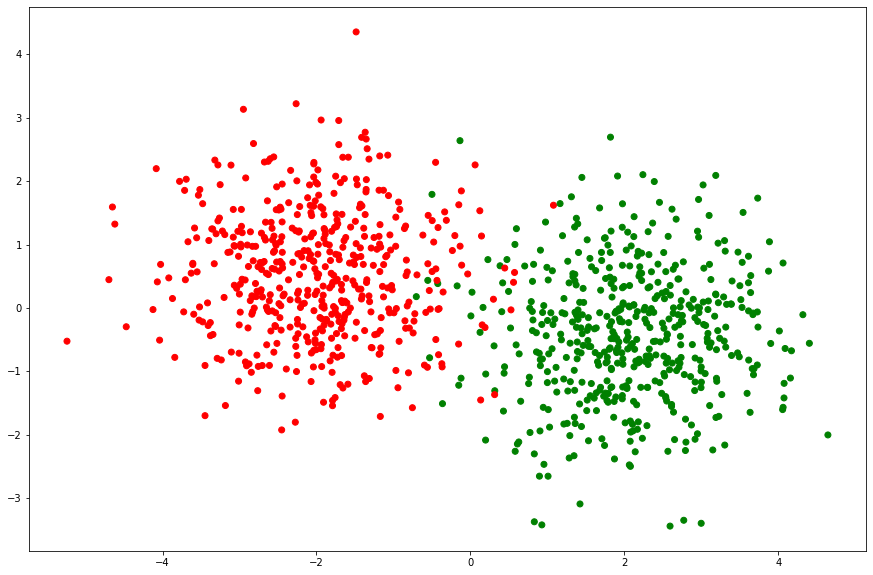

In [22]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=1000, centers=[[-2,0.5],[2,-0.5]], cluster_std=1, random_state=42)

colors = ("red", "green")
colored_y = np.zeros(y.size, dtype=str)

for i, cl in enumerate([0,1]):
    colored_y[y == cl] = str(colors[i])
    
plt.figure(figsize=(15,10))
plt.scatter(X[:, 0], X[:, 1], c=colored_y)
plt.show()

In [23]:
clf = MyLogisticRegression()

clf.fit(X, y, max_iter=1000)

w = clf.get_weights()

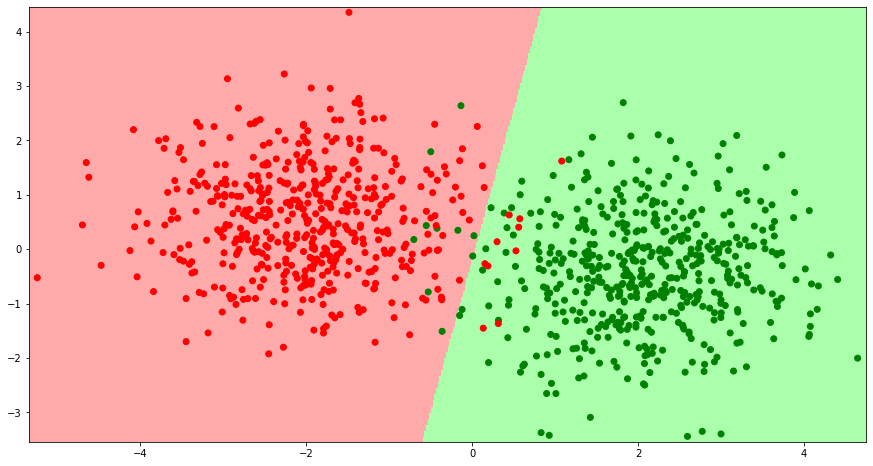

In [24]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

plt.figure(figsize=(15,8))

eps = 0.1
xx, yy = np.meshgrid(np.linspace(np.min(X[:,0]) - eps, np.max(X[:,0]) + eps, 500),
                     np.linspace(np.min(X[:,1]) - eps, np.max(X[:,1]) + eps, 500))

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)

cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

plt.scatter(X[:, 0], X[:, 1], c=colored_y)

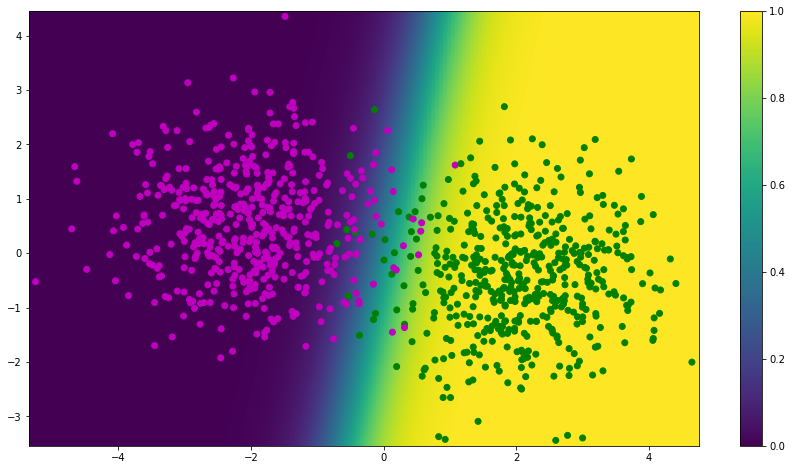

In [25]:
colors = ("magenta", "green")
colored_y = np.zeros(y.size, dtype=str)

for i, cl in enumerate([0,1]):
    colored_y[y == cl] = str(colors[i])


plt.figure(figsize=(15,8))

Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.get_cmap('viridis'))

plt.scatter(X[:, 0], X[:, 1], c=colored_y)
plt.colorbar()
plt.show()

# 3. О регуляризации

Зачастую модель обучается на каких-то зашумленных данных. Веса модели после обучения подбираются для уменьшения ошибки целевой функции. От различных выборках модель может обучаться по-разному, но нам бы хотелось вычленять основную зависимость примерно одинаково, то есть **не переобучаться (overfit)** на данных. Иначе обучившись на одном сете, мы можем получать неожиданный результат на других данных.

То есть мы хотели бы штрафовать модель за ее сложность, чтобы выискивать более простые зависимости.


Еще одной проблемой, специфичной для линейных моделей, является **мультиколлинеарность**. Особенность мультиколлинеарности заключается в том, что из-за того, что решений становится бесконечно много, коэффициенты модели могут принимать огромные значения. Отсюда вывод: необходимо каким-то образом ограничить величину коэффициентов модели.

Для линейной модели дополнительные ограничения на веса выполняют роль регуляризации. Различают:
- $l_1$-регуляризацию (LASSO, least absolute shrinkage and selection operator), учитывание $||w||_1$ 
- $l_2$-регуляризацию (Ridge), учитывание $||w||^2_2$
- Elastic net - комбинация двух предыдущих (учитываются обе нормы весов)

Далее напишем свои классы для Ridge и LASSO регрессий. Протестируем их на выборке из первого задания:

In [26]:
objects_num = 50
X = np.linspace(-5, 5, objects_num)
y = linear_expression(X) + np.random.randn(objects_num) * 5

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5)

# 4. Ridge регрессия (l2 регуляризация)

В ridge мы штрафуем модель также на сумму квадратов всех ее весов, таким образом:

**Лосс:** $L(w) = ||Xw - Y||^2_2 + \lambda||w||^2_2$, где $\lambda$ - гиперпараметр, отвечающий за степень регуляризации.

В привычном понимании:

**Лосс:** $L(w) = \sum_{i=1}^n\left(\sum_{j=1}^{m} x_{ij}w_j - y_i\right)^2 + \lambda\sum_{j=1}^{m}w_j^2$

Что стоит сказать про значения признаков? Они должны быть стандартизованы для одинаковых штрафов относительно друг друга! (используется связка с `sklearn.preprocessing.StandardScaler`)

Кстати, наблюдается довольно интересная особенность Ridge, из-за того как мы определили функцию потерь

In [27]:
reg = Ridge(alpha=1).fit(np.hstack((X, X, X))[:, np.newaxis], np.hstack((y, y, y)))
np.append(reg.coef_, reg.intercept_)

array([ 3.913095  , 29.86920102])

In [28]:
reg = Ridge(alpha=1/3).fit(X[:, np.newaxis], y)
np.append(reg.coef_, reg.intercept_)

array([ 3.913095  , 29.86920102])

### 4.1. Аналитическое решение

Из курса статистики известно если: 
$$ L(w) = ||Xw - Y||^2_2 + ||\Gamma w||^2_2 $$

минимизируется при:

$$ w = (X^TX + \Gamma^T \Gamma)^{-1}X^TY $$

В нашем случае $\Gamma^T\Gamma = \lambda I$, если нет свободного члена, иначе:
$\Gamma^T\Gamma =
\left(\begin{matrix}
\lambda I & 0 \\
0 & 0
\end{matrix}\right)$


In [29]:
class MyRidgeRegression(MyLinearRegression):
    def __init__(self, alpha=1.0, **kwargs):
        super().__init__(**kwargs)
        self.alpha = alpha
    
    def fit(self, X, y):
        n, m = X.shape
        X_train = X

        if self.fit_intercept:
            X_train = np.hstack((X, np.ones((n, 1))))
        
        lambdaI = self.alpha * np.eye(X_train.shape[1])
        if self.fit_intercept:
            lambdaI[-1, -1] = 0

        self.w = np.linalg.inv(X_train.T @ X_train + lambdaI) @ X_train.T @ y

        return self

    def get_weights(self):
        return self.w

Протестируем решение на нашем датасете:

In [30]:
alpha = 1.0
regressor = MyRidgeRegression(alpha=alpha).fit(X_train[:, np.newaxis], y_train)

Проверим работу, сравнив с `linear_model.Ridge` из sklearn

In [31]:
sklearn_reg = Ridge(alpha).fit(X_train[:, np.newaxis], y_train)
assert np.allclose(regressor.get_weights(), np.append(sklearn_reg.coef_, sklearn_reg.intercept_))
regressor.get_weights()

array([ 3.86192301, 29.11081032])

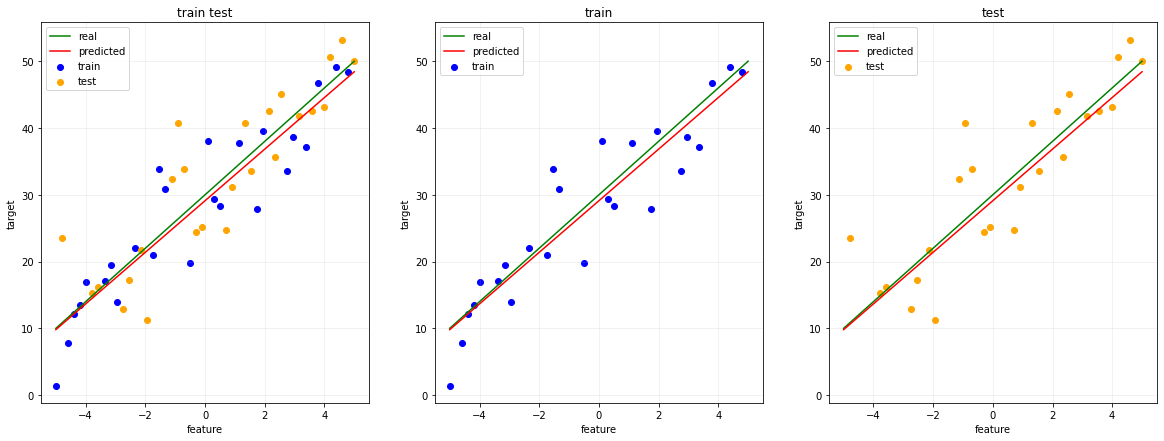

In [32]:
plt.figure(figsize=(20, 7))

ax = None

for i, types in enumerate([['train', 'test'], ['train'], ['test']]):
    ax = plt.subplot(1, 3, i + 1, sharey=ax)
    if 'train' in types:
        plt.scatter(X_train, y_train, label='train', c='b')
    if 'test' in types:
        plt.scatter(X_test, y_test, label='test', c='orange')

    plt.plot(X, linear_expression(X), label='real', c='g')
    plt.plot(X, regressor.predict(X[:, np.newaxis]), label='predicted', c='r')

    plt.ylabel('target')
    plt.xlabel('feature')
    plt.title(" ".join(types))
    plt.grid(alpha=0.2)
    plt.legend()

plt.show()

### 4.2 SGD

Аналогично предыдущим заданиям нужно рассчитать значение градиента $\displaystyle\frac{\partial{L}}{\partial{w}}$

**Имеем:**
$$
\begin{aligned}L(w) &= ||Xw - Y||^2_2 + ||\Gamma w||^2_2
= (Xw - Y)^T(Xw - Y) + w^T\Gamma^T\Gamma w = \\
&= w^TX^TXw - 2Y^TXw + Y^TY + w^T\Gamma^T\Gamma w =
w^T(X^TX + \Gamma^T\Gamma)w - 2Y^TXw + Y^TY
\end{aligned}
$$

**Градиент:**
$$
\frac{\partial{L}}{\partial{w}}
= 2(X^TX + \Gamma^T\Gamma)w - 2X^TY
$$

Будем также усреднять значения лосса по батчу данных ($\displaystyle\frac{1}{n_{sample}}$ появится)

Реализуем наш класс Ridge регрессии используя стохастический градиентный спуск


In [33]:
class MySGDRidge(MySGDLinearRegression):
    def __init__(self, alpha=1.0, **kwargs):
        super().__init__(**kwargs) # передает именные параметры родительскому конструктору
        self.w = None
        self.alpha = alpha

    def _calc_gradient(self, X, y, y_pred):
        # Главное отличие в SGD - это использование подвыборки для шага оптимизации
        inds = np.random.choice(np.arange(X.shape[0]), size=self.n_sample, replace=False)

        lambdaI = self.alpha * np.eye(self.w.shape[0])
        if self.fit_intercept:
            lambdaI[-1, -1] = 0

        grad = 2 * (X[inds].T @ X[inds] / self.n_sample + lambdaI) @ self.w
        grad -= 2 * X[inds].T @ y[inds] / self.n_sample

        return grad

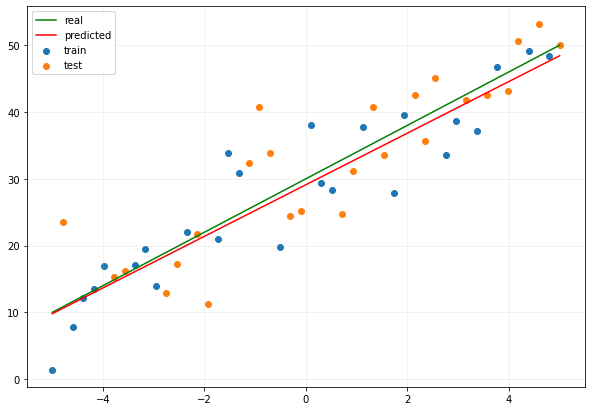

In [34]:
plt.figure(figsize=(10, 7))
plt.plot(X, linear_expression(X), label='real', c='g')

plt.scatter(X_train, y_train, label='train')
plt.scatter(X_test, y_test, label='test')
plt.plot(X, regressor.predict(X[:, np.newaxis]), label='predicted', c='r')

plt.grid(alpha=0.2)
plt.legend()
plt.show()

In [35]:
regressor = MySGDRidge(alpha=1, n_sample=20).fit(X[:, np.newaxis], y, max_iter=1000, lr=0.01)
l = regressor.get_losses()
regressor.get_weights()

array([ 3.54985408, 29.89648441])

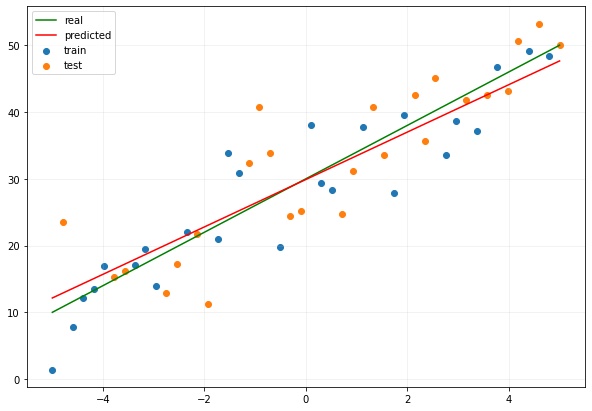

In [36]:
plt.figure(figsize=(10, 7))
plt.plot(X, linear_expression(X), label='real', c='g')

plt.scatter(X_train, y_train, label='train')
plt.scatter(X_test, y_test, label='test')
plt.plot(X, regressor.predict(X[:, np.newaxis]), label='predicted', c='r')

plt.grid(alpha=0.2)
plt.legend()
plt.show()

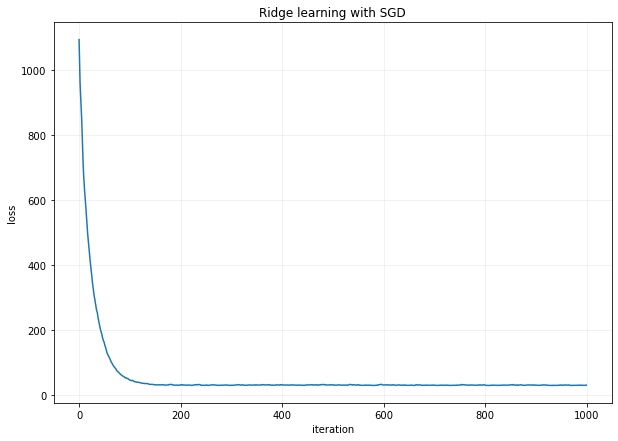

In [37]:
plt.figure(figsize=(10, 7))

plt.plot(l)

plt.title('Ridge learning with SGD')
plt.ylabel('loss')
plt.xlabel('iteration')
plt.grid(alpha=0.2)
plt.show()

# 5. LASSO регрессия (l1 регуляризация)

В LASSO мы штрафуем модель также **на сумму модулей всех ее весов** (на l1-норму весов), таким образом:

**Лосс:** $L(w) = \frac{1}{2n} ||Xw - Y||^2_2 + \lambda ||w||_1$, где $\lambda$ - гиперпараметр, отвечающий за степень регуляризации.

В привычном понимании:

**Лосс:** $L(w) = \frac{1}{2n}\sum_{i=1}^n\left(\sum_{j=1}^{m} x_{ij}w_j - y_i\right)^2 + \lambda\sum_{j=1}^{m}|w_j|$

Признаки опять же должны быть стандартизованы для одинаковых штрафов относительно друг друга!

В Lasso наблюдается поведение, которое нам бы и хотелось видеть

In [38]:
reg = Lasso(alpha=1).fit(np.hstack((X, X, X))[:, np.newaxis], np.hstack((y, y, y)))
np.append(reg.coef_, reg.intercept_)

array([ 3.8008086 , 29.86920102])

In [39]:
reg = Lasso(alpha=1).fit(X[:, np.newaxis], y)
np.append(reg.coef_, reg.intercept_)

array([ 3.8008086 , 29.86920102])

### 4.1 Аналитическое решение

В отличие от Ridge, аналитическое решение задачи Lasso регрессии в общем случае не находится.

### 4.2 SGD

Аналогично предыдущим заданиям для SGD нужно рассчитать значение градиента $\displaystyle\frac{\partial{L}}{\partial{w}}$

**Лосс:**
$$
\begin{aligned}L(w) &= \frac{1}{2n}||Xw - Y||^2_2 + ||\Gamma w||_1
= \frac{1}{2n}(Xw - Y)^T(Xw - Y) + ||\Gamma w||_1 = \\
&= \frac{1}{2n}(w^TX^TXw - 2Y^TXw + Y^TY) + \lambda\sum_{i=1}^{m-1}|w|
\end{aligned}
$$

**Градиент:**
$$
\frac{\partial{L}}{\partial{w}}
= \frac{1}{n}(X^TXw - X^TY) + \lambda sign(w)
= \frac{1}{n}X^T(y_{pred} - Y) + \lambda sign(w)
$$

где для приближения будем считать что $|\cdot|$ - дифференцируемая функция, ее производной является $sign(\cdot)$

Реализуем наш класс Ridge регрессии, используя стохастический градиентный спуск


In [40]:
def soft_sign(x, eps=1e-7):
    if abs(x) > eps:
        return np.sign(x)
    return x / eps

np_soft_sign = np.vectorize(soft_sign)

class MySGDLasso(MySGDLinearRegression):
    def __init__(self, alpha=1.0, **kwargs):
        super().__init__(**kwargs) # передает именные параметры родительскому конструктору
        self.w = None
        self.alpha = alpha

    def _calc_gradient(self, X, y, y_pred):
        # Главное отличие в SGD - это использование подвыборки для шага оптимизации
        inds = np.random.choice(np.arange(X.shape[0]), size=self.n_sample, replace=False)

        signw = np_soft_sign(self.w)
        if self.fit_intercept:
            signw[-1] = 0

        grad = X[inds].T @ (y_pred[inds] - y[inds])[:, np.newaxis] / self.n_sample
        grad += self.alpha * signw[:, np.newaxis]

        return grad.flatten()

Протестируем

In [41]:
regressor = MySGDLasso(alpha=1, n_sample=4).fit(X[:, np.newaxis], y, max_iter=1000, lr=0.01)
l = regressor.get_losses()
regressor.get_weights()

array([ 3.76586786, 30.07256217])

In [42]:
sklearn_reg = Lasso().fit(X[:, np.newaxis], y)
np.append(sklearn_reg.coef_, sklearn_reg.intercept_)

array([ 3.8008086 , 29.86920102])

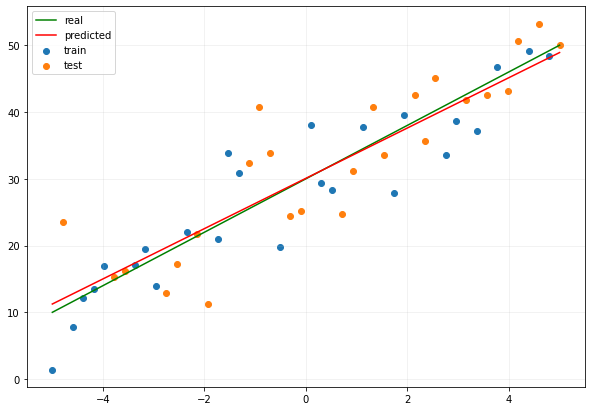

In [43]:
plt.figure(figsize=(10, 7))
plt.plot(X, linear_expression(X), label='real', c='g')

plt.scatter(X_train, y_train, label='train')
plt.scatter(X_test, y_test, label='test')
plt.plot(X, regressor.predict(X[:, np.newaxis]), label='predicted', c='r')

plt.grid(alpha=0.2)
plt.legend()
plt.show()

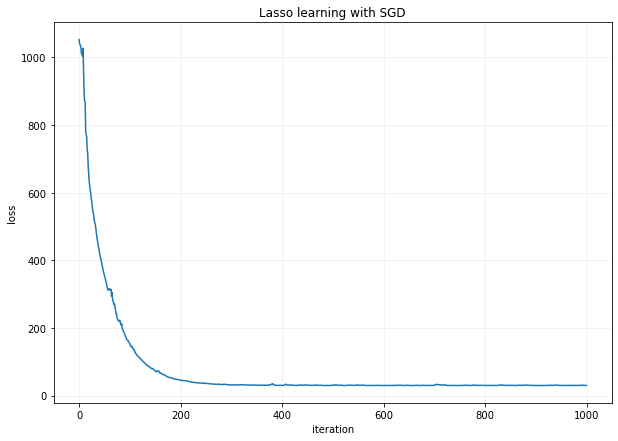

In [44]:
plt.figure(figsize=(10, 7))

plt.plot(l)

plt.title('Lasso learning with SGD')
plt.ylabel('loss')
plt.xlabel('iteration')
plt.grid(alpha=0.2)
plt.show()

# Различия LASSO и Ridge

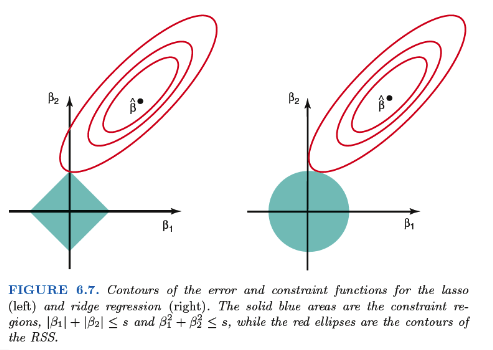

Различий несколько между $l_1$ и $l_2$ регуляризациями:

- Lasso **сложнее считать** из-за недифференцируемых углов шара в $l_1$ норме (в значении нуля для признаков)
- **отсутствие аналитического решения** делает вычисления и теоретические значения весов при $l_1$ регуляризации более сложными
- В Lasso появляется **зануление весов** для некоторых признаков

Протестируем методы на реальных данных

In [45]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

import pandas as pd
import seaborn as sns

In [46]:
iris = load_iris()

In [47]:
data = pd.DataFrame(data=np.hstack([iris.data, iris.target[:, np.newaxis]]), 
                    columns=iris.feature_names + ['target'])

names = data.columns
data.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


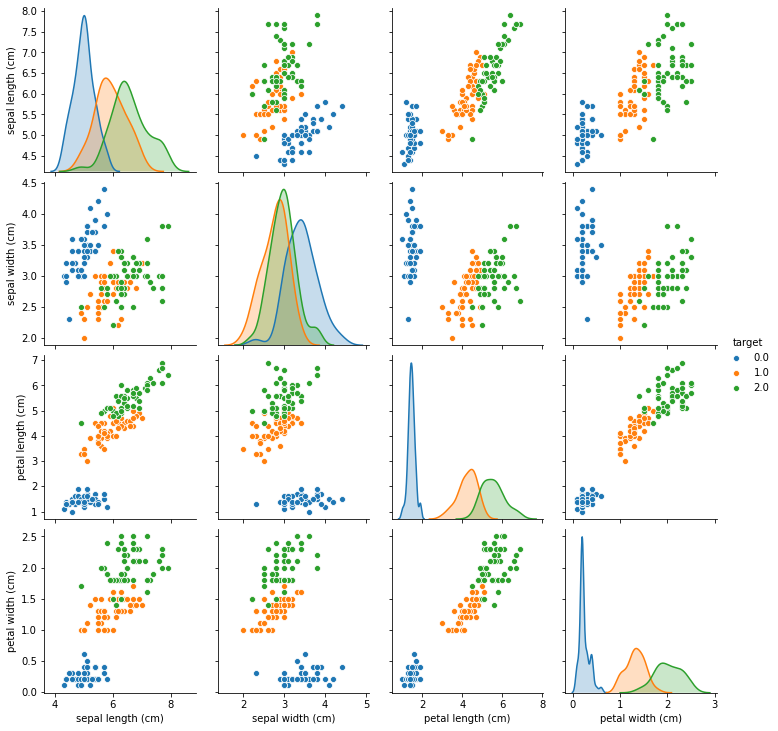

In [48]:
sns.pairplot(data, hue='target')

plt.show()

In [49]:
X_train, X_test, y_train, y_test = train_test_split(data[names[:-1]], data[names[-1]])

In [50]:
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, f1_score

In [51]:
cls = make_pipeline(
    StandardScaler(),
    LogisticRegression(C=2)
)
cls = cls.fit(X_train.to_numpy(), y_train)
preds_train = cls.predict(X_train)

accuracy_score(preds_train, y_train), f1_score(preds_train, y_train, average='macro')

(0.9821428571428571, 0.9822190611664295)

In [52]:
preds_test = cls.predict(X_test)

accuracy_score(preds_test, y_test), f1_score(preds_test, y_test, average='macro')

(0.9473684210526315, 0.945887445887446)

In [53]:
# cls.coef_, cls.intercept_
cls[1].coef_, cls[1].intercept_

(array([[-1.1925417 ,  1.33531362, -2.20201428, -2.10068735],
        [ 0.67252242, -0.22381385, -0.67396055, -0.7646085 ],
        [ 0.52001928, -1.11149977,  2.87597483,  2.86529585]]),
 array([-0.19793896,  2.49426682, -2.29632787]))

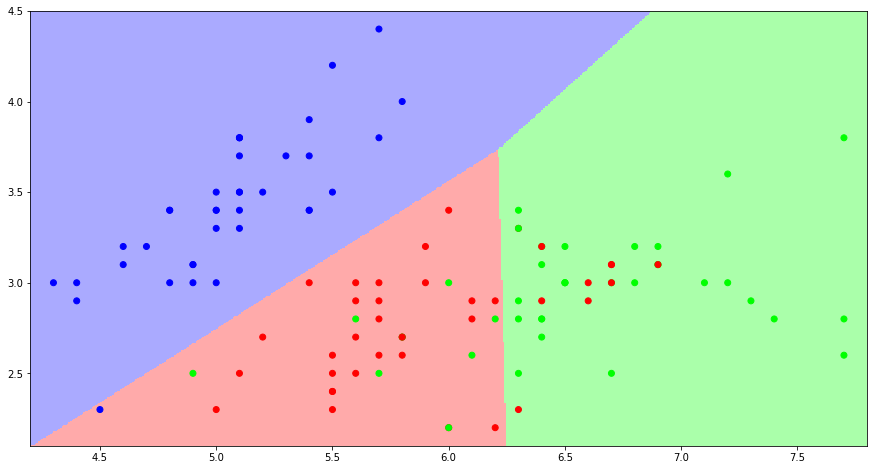

In [54]:
from matplotlib.colors import ListedColormap

plt.figure(figsize=(15,8))

eps = 0.1
xx, yy = np.meshgrid(np.linspace(np.min(X_train[names[0]]) - eps, np.max(X_train[names[0]]) + eps, 500),
                     np.linspace(np.min(X_train[names[1]]) - eps, np.max(X_train[names[1]]) + eps, 500))



cls.fit(X_train[names[:2]], y_train)
Z = cls.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)

cmap_light = ListedColormap(['#AAAAFF', '#FFAAAA', '#AAFFAA'])
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

plt.scatter(X_train[names[0]], X_train[names[1]], c=y_train, cmap='brg')